## Import necessary modules
Dependencies:
 - numpy
 - pandas
 - matplotlib

In [43]:
import numpy as np
import pandas as pd
import pickle
import sys
sys.path.append("../src/")
from lbd_functions import plot_elevation,plot3sections,plot3Dreal,printtimelogwithstarline,printtimelog
from lbd_functions import gen_concatenated_lenses_params,gen_facies_youth_mx,get_facies_prop
from lbd_functions import Lense, get_model_dh_litho_thickness, get_model_litho_thickness,plot_clay_and_sand_ecdfs_err
from utils import check_plot_2_sections, get_ecdf, interp_ecdf_normalize_x, interpolate_ecdf, get_ecdf_area_difference
from scipy.interpolate import RegularGridInterpolator

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import matplotlib.pyplot as plt

from pyevtk.hl import gridToVTK

top_basement_fn = '../data/interfaces-sediment-basement/bot_base.npy'
top_weathered_basement_fn = '../data/interfaces-sediment-basement/bot_delt.npy'
top_deltaic_sediments_fn = '../data/interfaces-sediment-basement/top_delt.npy'

# bh_summary_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_summary.csv'
# ref_err_fn = '../data/boreholes-processed/LBW_extended_error-tolerance.pickle'
bh_summary_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_corrected_summary.csv'
ref_err_fn = '../data/boreholes-processed/LBW_extended_corrected_error-tolerance.pickle'

output_fd = '../data/models-age-facies/'
fig_fd = '../figures/'

stat2_fn = 'stats_1_real_100subsamples_corrected.csv'
nseeds= 100

plot=True
Verb=True

## Parameters
Loading model parameters by running the parameter file

In [44]:
# DEFINE RANGE FOR PARAMETERS TO EXPLORE from analysis of bo-simple-logs_v0.json
intensity_sand = 0.14998042644940118 #0.1357085524950305
intensity_clay = 0.1425699959271289 #0.10254000999344669

truncation_sand = 0.3 # 0.2
truncation_clay = 0.3 # 0.2
thickness_sand = 4.741808887538607 # 4.0
thickness_clay = 2.932357270809662 # 3.0
length_sand = 3925.6342497692663 # 6000.0
length_clay = 4291.846227222251 # 6000.0

seed_increment = 2 # 0,1 and 2
filename_suffix = "_real_"+str(seed_increment)

print(filename_suffix)

_real_2


In [45]:
# DEFINE FIXED PARAMETERS
intensity_tol = 5.0/100
truncation_tol = 7.5/100
length_tol = 50/100
thickness_tol = 40/100
truncationdist = 'uniform'
lengthdist = 'uniform'
thicknessdist = 'uniform'
anisotropy = 4
anisotropy_tol = 2
anisotropydist = 'uniform'
dipdir = 90*np.pi/180 # in radians
dipdir_tol = 10*np.pi/180 # in radians
dipdirdist = 'normal'
dip = 0
dip_tol = 0
dipdist = 'normal'
facies_sand = 2
facies_clay = 3

printtimelogwithstarline('DEFINE PARAMETERS')
lbdseed = 12345

printtimelog('model boundaries')
xmin=5.30E5
xmax=5.45E5
ymin=7.830E6
ymax=7.842E6
zmin=-80
zmax=20
dx=dy=250
dz=1

lithocodes = [-1,0,1,2,3]
labels = ["basement","weathered-basement","intermediate","coarse-grained","fine-grained"]
lithocolors = ["pink","lavenderblush", "sienna", "gold", "grey"]
ndhsamples = 500 # to estimate thicknesses from generated models
rng = np.random.default_rng(lbdseed) # +seed_increment

**********************************************************************
26-Feb-2025 (09:44:58) - DEFINE PARAMETERS
**********************************************************************
26-Feb-2025 (09:44:58) - model boundaries


## Processing input data

In [46]:

# PROCESSING INPUT DATA
# AREA OF INTEREST GRID
aoi_nx = int((xmax-xmin)/dx)
aoi_ny = int((ymax-ymin)/dy)
aoi_nz = int((zmax-zmin)/dz)
aoi_vx = np.linspace(xmin+dx/2,xmax-dx/2,aoi_nx,endpoint=True)
aoi_vy = np.linspace(ymin+dy/2,ymax-dy/2,aoi_ny,endpoint=True)
aoi_vz = np.linspace(zmin+dz/2,zmax-dz/2,aoi_nz,endpoint=True)
aoi_xx,aoi_yy = np.meshgrid(aoi_vx,aoi_vy,indexing='xy')
aoi_pts = np.array([aoi_xx.flatten(),aoi_yy.flatten()]).T
# LOAD INTERFACES
top_basement =  np.load(top_basement_fn)
top_weathered_basement =  np.load(top_weathered_basement_fn)
top_deltaic_sediments =  np.load(top_deltaic_sediments_fn)
# GET INTERFACES DIMENSIONS
top_nx = len(np.unique(top_basement[:,0]))
top_ny = len(np.unique(top_basement[:,1]))
# GET INTERFACES X & Y COORDINATES
top_xx = np.flipud(np.reshape(top_basement[:,0],(top_ny,top_nx)))
top_yy = np.flipud(np.reshape(top_basement[:,1],(top_ny,top_nx)))
# RESHAPE INTERFACES AS 2D ARRAYS
zz_top_basement = np.flipud(np.reshape(top_basement[:,-1],(top_ny,top_nx)))
zz_top_weathered_basement = np.flipud(np.reshape(top_weathered_basement[:,-1],(top_ny,top_nx)))
zz_top_deltaic_sediments = np.flipud(np.reshape(top_deltaic_sediments[:,-1],(top_ny,top_nx)))
# ESTIMATE INTERFACES MASK
mask = zz_top_basement< zz_top_basement.max()
# APPLY MASK TO REMOVE MAX PLATEAU VALUES
zz_top_basement[mask==False]=np.nan
zz_top_weathered_basement[mask==False]=np.nan
zz_top_deltaic_sediments[mask==False]=np.nan
# ESTIMATE RESOLUTION
xc_min = top_basement[:,0].min()
xc_max = top_basement[:,0].max()
top_dx = (xc_max-xc_min)/(top_nx-1)
yc_min = top_basement[:,1].min()
yc_max = top_basement[:,1].max()
top_dy = (yc_max-yc_min)/(top_ny-1)
# INDEX OF INTERFACES IMAGES TO SELECT TO BUILD INTERPOLATOR
ix_select = (np.where(
    (top_xx >= xmin-top_dx) & (top_xx <= xmax+top_dx) &
    (top_yy >= ymin-top_dy) & (top_yy <= ymax+top_dy)
))
top_vx = np.sort(np.unique(top_xx[ix_select]))
top_vy = np.sort(np.unique(top_yy[ix_select]))
    
ori_top_basement = np.reshape(zz_top_basement[ix_select],(len(top_vy),len(top_vx)))
ori_top_weathered_basement = np.reshape(zz_top_weathered_basement[ix_select],(len(top_vy),len(top_vx)))
ori_top_deltaic_sediments = np.reshape(zz_top_deltaic_sediments[ix_select],(len(top_vy),len(top_vx)))

# DEFINE INTERPOLATORS
# # flip on y axis because of increasing vy
# data_tbt = np.flipud(ori_top_basement)
# data_twb = np.flipud(ori_top_weathered_basement)
# data_tds = np.flipud(ori_top_deltaic_sediments)

interp_top_basement = RegularGridInterpolator((top_vy, top_vx),ori_top_basement)
interp_top_weathered_basement = RegularGridInterpolator((top_vy, top_vx), ori_top_weathered_basement)
interp_top_deltaic_sediments = RegularGridInterpolator((top_vy, top_vx), ori_top_deltaic_sediments)

# INTERPOLATE INTERFACES
aoi_pts = np.array([aoi_yy.flatten(),aoi_xx.flatten()]).T    
aoi_top_basement = np.reshape(interp_top_basement(aoi_pts),(aoi_ny,aoi_nx))
aoi_top_weathered_basement = np.reshape(interp_top_weathered_basement(aoi_pts),(aoi_ny,aoi_nx))
aoi_top_deltaic_sediments = np.reshape(interp_top_deltaic_sediments(aoi_pts),(aoi_ny,aoi_nx))

# CREATE GRID
zzz,yyy,xxx = np.meshgrid(aoi_vz,aoi_vy,aoi_vx,indexing='ij')

# CREATE AQUIFER MASK
# 0 basement
# 1 aquifer domain
# np.nan above topography
tmp_twb = np.tile(np.reshape(aoi_top_weathered_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
tmp_tds = np.tile(np.reshape(aoi_top_deltaic_sediments,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
mask_aquifer = np.zeros((aoi_nz,aoi_ny,aoi_nx))
ix_aq = np.where((zzz>=tmp_twb)&(zzz<=tmp_tds))
mask_aquifer[ix_aq] = 1
ix_air = np.where(zzz>tmp_tds)
mask_aquifer[ix_air] = np.nan

printtimelog('load LBD 1-point statistics')
f = open(ref_err_fn, 'rb')
[prop_clay_mean_p5_p95, prop_sand_mean_p5_p95, prop_inte_mean_p5_p95,
 prop_clay_err_mean_p5_p95, prop_sand_err_mean_p5_p95, prop_inte_err_mean_p5_p95,
 ecdf_clay_mean_p5_p95, ecdf_sand_mean_p5_p95, ecdf_inte_mean_p5_p95, x01_vec, thickness_lim,
 ecdf_clay_area_err_mean_p5_p95, ecdf_sand_area_err_mean_p5_p95, ecdf_inte_area_err_mean_p5_p95] = pickle.load(f)
f.close()
nbins = len(x01_vec)-1
xlim = thickness_lim[1]


26-Feb-2025 (09:44:58) - load LBD 1-point statistics


## Building a facies model

In [47]:
intensity_sand_tol = intensity_tol * intensity_sand
intensity_clay_tol = intensity_tol * intensity_clay
length_sand_tol = length_tol * length_sand
length_clay_tol = length_tol * length_clay
thickness_sand_tol = thickness_tol *thickness_sand 
thickness_clay_tol = thickness_tol *thickness_clay 
# DEFINE LENSES CLASSES
sandLenses = Lense(intensity_sand,intensity_sand_tol,
                 truncation_sand,truncation_tol,truncationdist,
                 length_sand,length_sand_tol,lengthdist,
                 thickness_sand,thickness_sand_tol,thicknessdist,
                 anisotropy,anisotropy_tol,anisotropydist,
                 dipdir,dipdir_tol,dipdirdist,
                 dip,dip_tol,dipdist,facies_sand)
clayLenses = Lense(intensity_clay,intensity_clay_tol,
                 truncation_clay,truncation_tol,truncationdist,
                 length_clay,length_clay_tol,lengthdist,
                 thickness_clay,thickness_clay_tol,thicknessdist,
                 anisotropy,anisotropy_tol,anisotropydist,
                 dipdir,dipdir_tol,dipdirdist,
                 dip,dip_tol,dipdist,facies_clay)

# GENERATE TRUNCATED ELLIPSOID PARAMS FOR SAND LENSES AND CLAY LENSES
#printtimelog('generate lense params')
lenseClassesList = [sandLenses,clayLenses]
Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies = gen_concatenated_lenses_params(lenseClassesList,mask_aquifer,dx,dz,lbdseed+3+seed_increment)

# GENERATE OBJECT BASED MODELS
#printtimelog('generate object based model')
facies_mx,relative_youth_mx = gen_facies_youth_mx(aoi_vx,aoi_vy,aoi_vz,Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies,mask_aquifer)

# ADD DISTINCTION BETWEEN BASEMENT AND WEATHERED BASEMENT
#printtimelog('differentiate basement from weathered basement')
tmp_twt = np.tile(np.reshape(aoi_top_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
ix_bst = np.where(zzz<tmp_twt)
facies_mx[ix_bst]=-1
 

In [48]:
# SAVE NUMPY ARRAYS TO FILE
outfile = output_fd+"calibrated_model"+filename_suffix+'.npz'
print(outfile)
np.savez(outfile, facies_mx=facies_mx,relative_youth_mx=relative_youth_mx, mask_aquifer=mask_aquifer,
         lithocodes=lithocodes,labels=labels,lithocolors=lithocolors,vx=aoi_vx,vy=aoi_vy,vz=aoi_vz)
# _ = outfile.seek(0)
npzfile = np.load(outfile)
sorted(npzfile.files)


../data/models-age-facies/calibrated_model_real_2.npz


['facies_mx',
 'labels',
 'lithocodes',
 'lithocolors',
 'mask_aquifer',
 'relative_youth_mx',
 'vx',
 'vy',
 'vz']

In [49]:
npzfile['vz']

array([-79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5,
       -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5,
       -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5,
       -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5, -44.5,
       -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5,
       -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5, -26.5,
       -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5, -17.5,
       -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,
        -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,
         1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,
        19.5])

In [50]:
zmin

-80

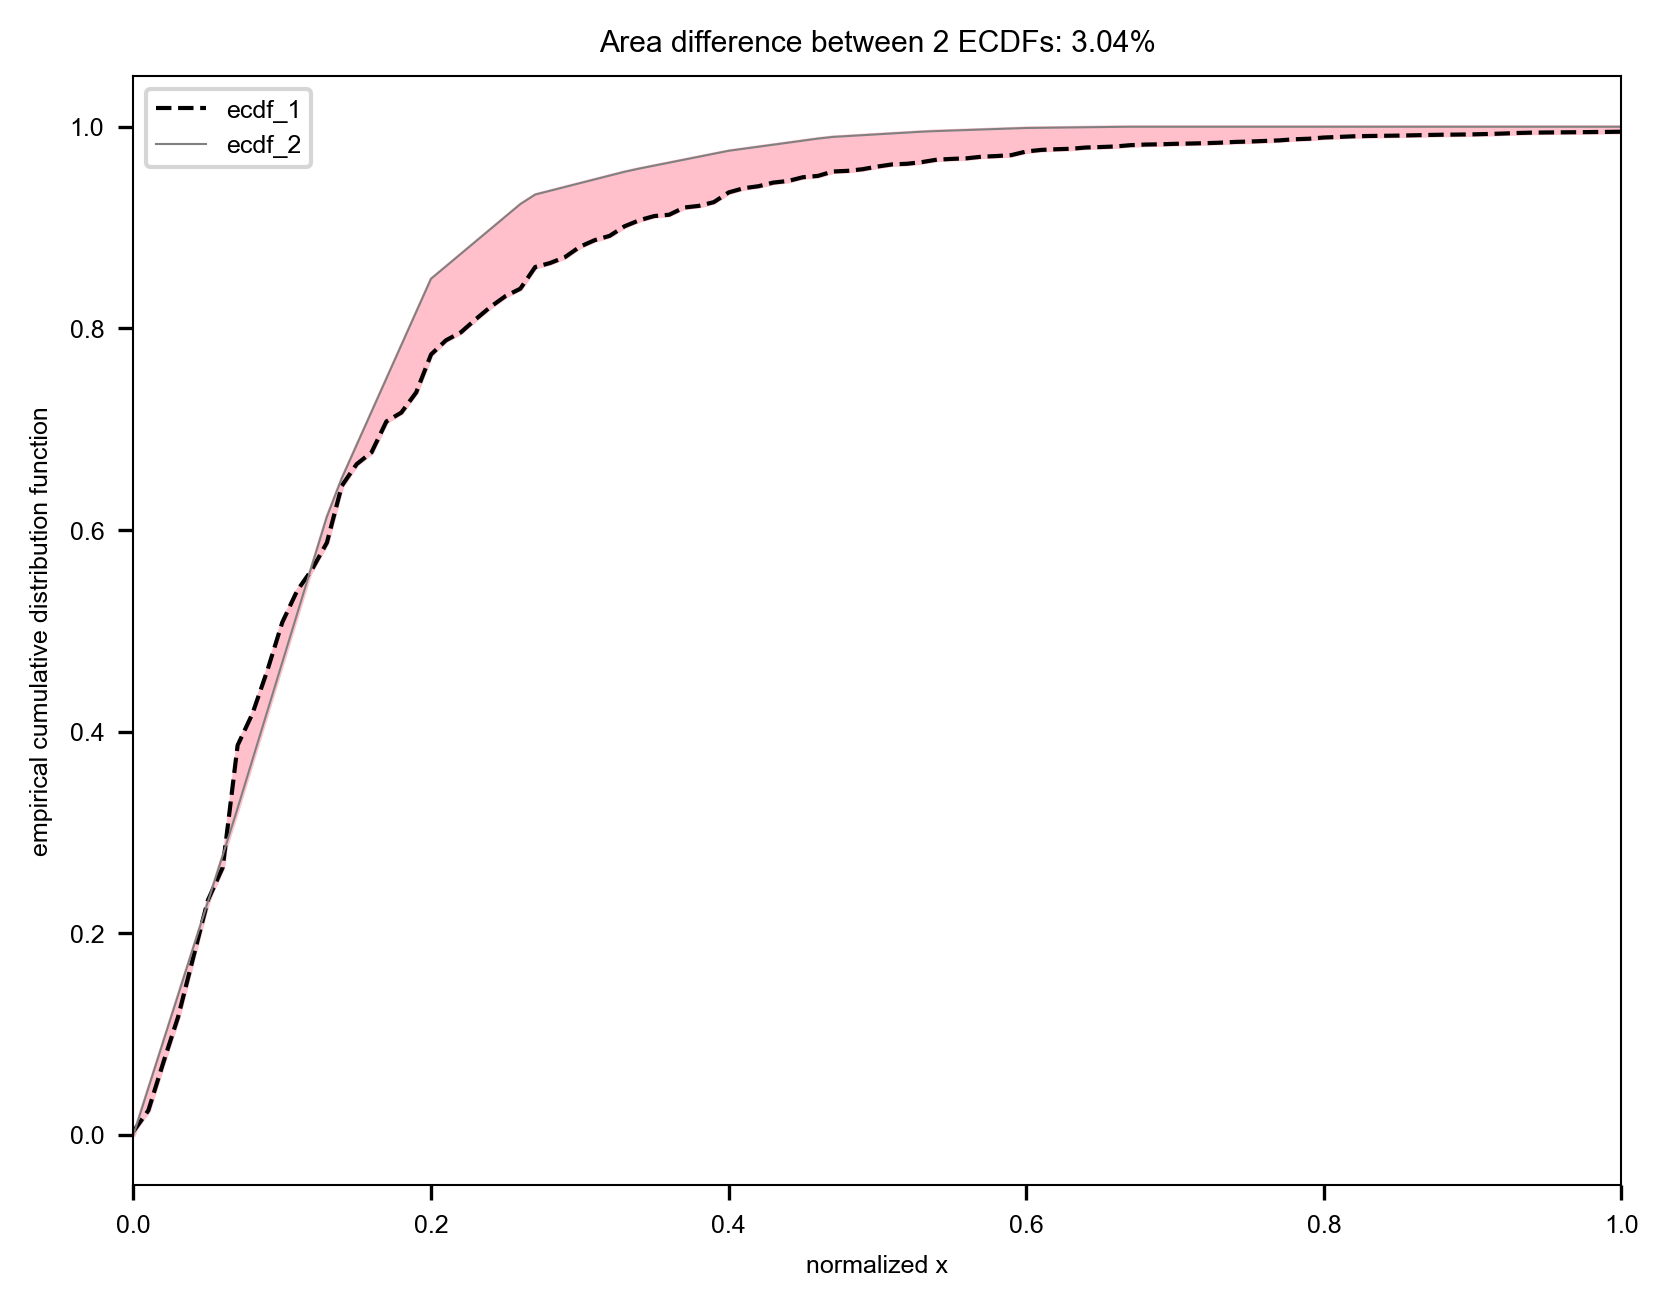

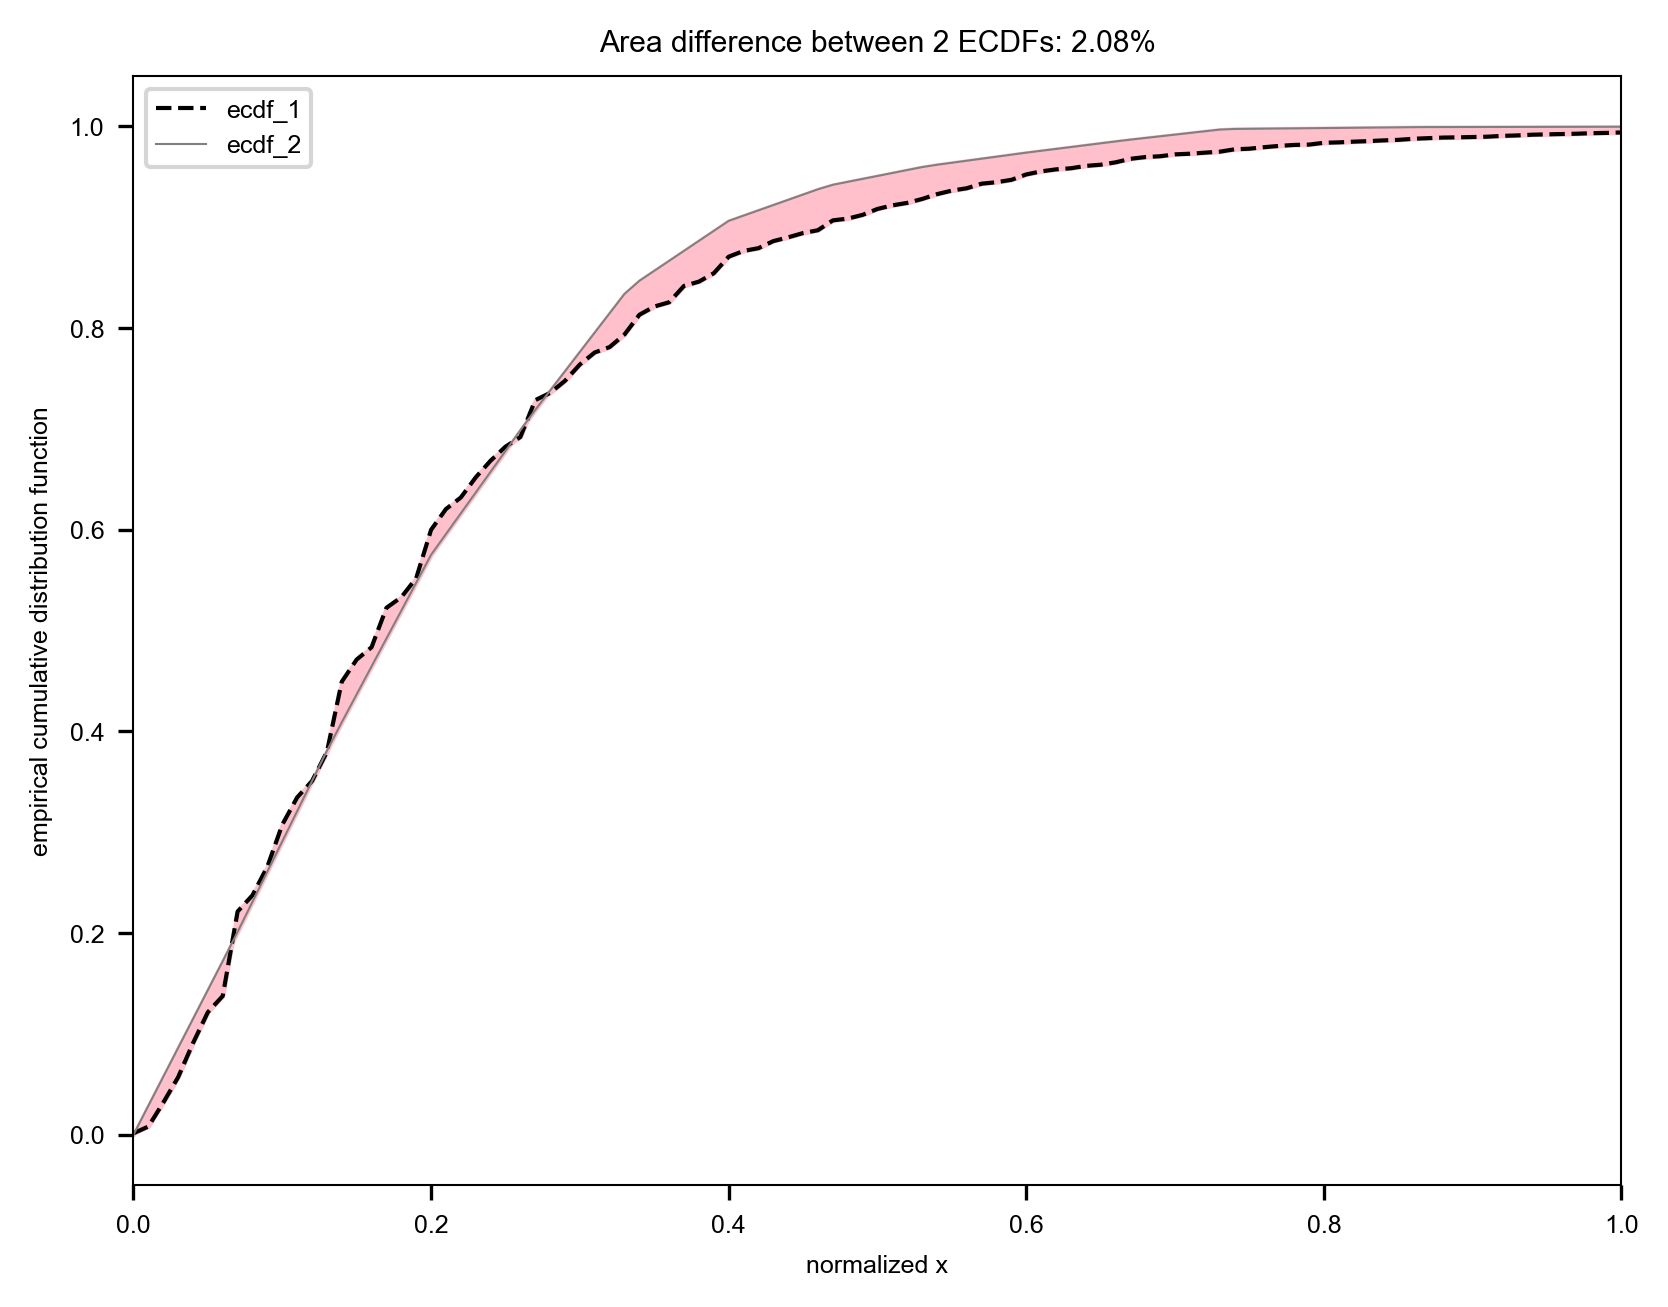

In [51]:
# COMPUTE COUNT AND PROPORTIONS PER LITHOCODE
#printtimelog('compute proportions')
prop = get_facies_prop(facies_mx,mask_aquifer,lithocodes[2:],labels[2:])
#print(prop)

# GET THICKNESSES
#printtimelog('extract thicknesses')
df_model_thickness = get_model_litho_thickness(facies_mx,ndhsamples,aoi_nx,aoi_ny,lithocodes,zmin,dz,rng)

# COMPUTE EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTIONS OF THICKNESS PER LITHOCODE
#printtimelogwithstarline('COMPUTE ECDFs')
x_clay, ecdf_clay = get_ecdf(df_model_thickness,3)
x_sand, ecdf_sand = get_ecdf(df_model_thickness,2)
x_inte, ecdf_inte = get_ecdf(df_model_thickness,1)

#printtimelog('normalize ecdfs')

ecdf01_clay = interp_ecdf_normalize_x(x_clay,ecdf_clay,xlim,x01_vec)
ecdf01_sand = interp_ecdf_normalize_x(x_sand,ecdf_sand,xlim,x01_vec)
ecdf01_inte = interp_ecdf_normalize_x(x_inte,ecdf_inte,xlim,x01_vec)

#printtimelogwithstarline('COMPUTE DISTANCE TO LBD DATASET')
#printtimelog('compute errors')
err_prop_clay = (float(prop.loc[3,'proportion'])/100-prop_clay_mean_p5_p95[0]) # / prop_clay_err_mean_p5_p95[0]
err_prop_sand = (float(prop.loc[2,'proportion'])/100-prop_sand_mean_p5_p95[0]) #/ prop_sand_err_mean_p5_p95[0]


err_ecfd_clay,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_clay_mean_p5_p95[:,0],x01_vec,ecdf01_clay,nbins=nbins,plot=True) #/ ecdf_clay_area_err_mean_p5_p95[0]
err_ecfd_sand,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_sand_mean_p5_p95[:,0],x01_vec,ecdf01_sand,nbins=nbins,plot=True) #/ ecdf_sand_area_err_mean_p5_p95[0]
# err_ratio_ecfd_inte,_,_,_,_,_, = get_ecdf_area_difference(x01_vec,ecdf_inte_mean_p5_p95[:,0],x01_vec,ecdf01_inte,nbins=nbins) #/ ecdf_inte_area_err_mean_p5_p95[0]

#printtimelog('compute distance')
errors = np.abs(np.array([err_prop_clay,err_prop_sand,err_ecfd_clay,err_ecfd_sand]))
#print('errors: '+str(errors))

similarity = np.prod(1-errors)**(1/len(errors))
dist2lbd = 1 - similarity
#print('dist2lbd: '+str(dist2lbd))   

In [52]:
print('errors: '+str(errors))
#similarity
print('similarity: '+str(similarity))


errors: [0.02010225 0.02751625 0.03039423 0.02075593]
similarity: 0.9752979555410479


In [53]:
np.mean(errors)


0.02469216486129202

../figures/fig7_thickness_ecdf_err_real_2_15cm_ft6.png


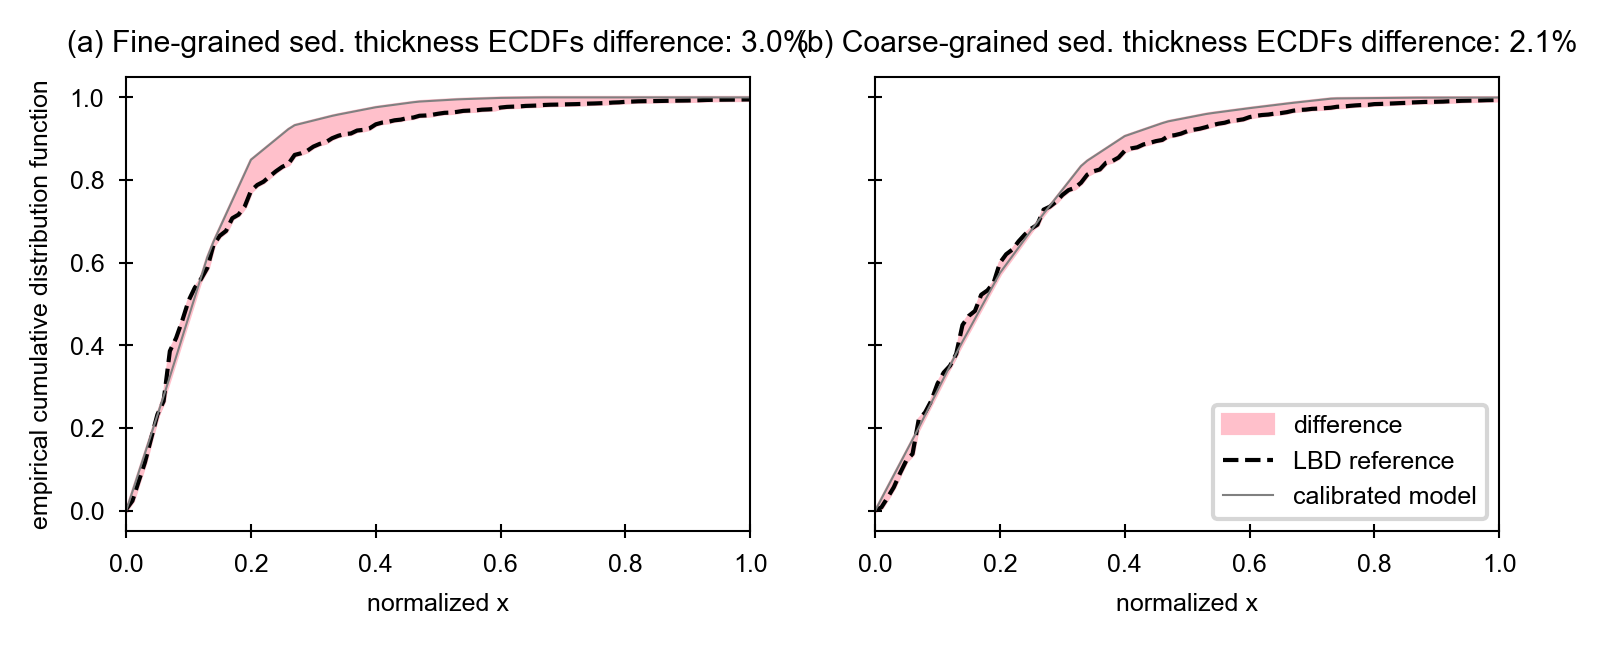

In [54]:
# nbins = 100
# x01_vec = np.linspace(0,1.0,num=(nbins+1), endpoint=True)
fgw = 15
fts = 6

ecdf_clay_ref = ecdf_clay_mean_p5_p95[:,0]
ecdf_sand_ref = ecdf_sand_mean_p5_p95[:,0]
figFileName = fig_fd+'fig7_thickness_ecdf_err'+filename_suffix+'_'+str(fgw)+'cm_ft'+str(fts)+'.png'
print(figFileName)
plot_clay_and_sand_ecdfs_err(ecdf_clay_ref,ecdf_sand_ref,x01_vec,ecdf01_clay,ecdf01_sand,figsize=(fgw/2.54,fgw/15*5/2.54),fontsize=fts,figFileName=figFileName)

## View model sections

26-Feb-2025 (09:45:01) - plotting sections - facies
../figures/fig8_3Dmodel_facies_real_2_15cm_ft6.png


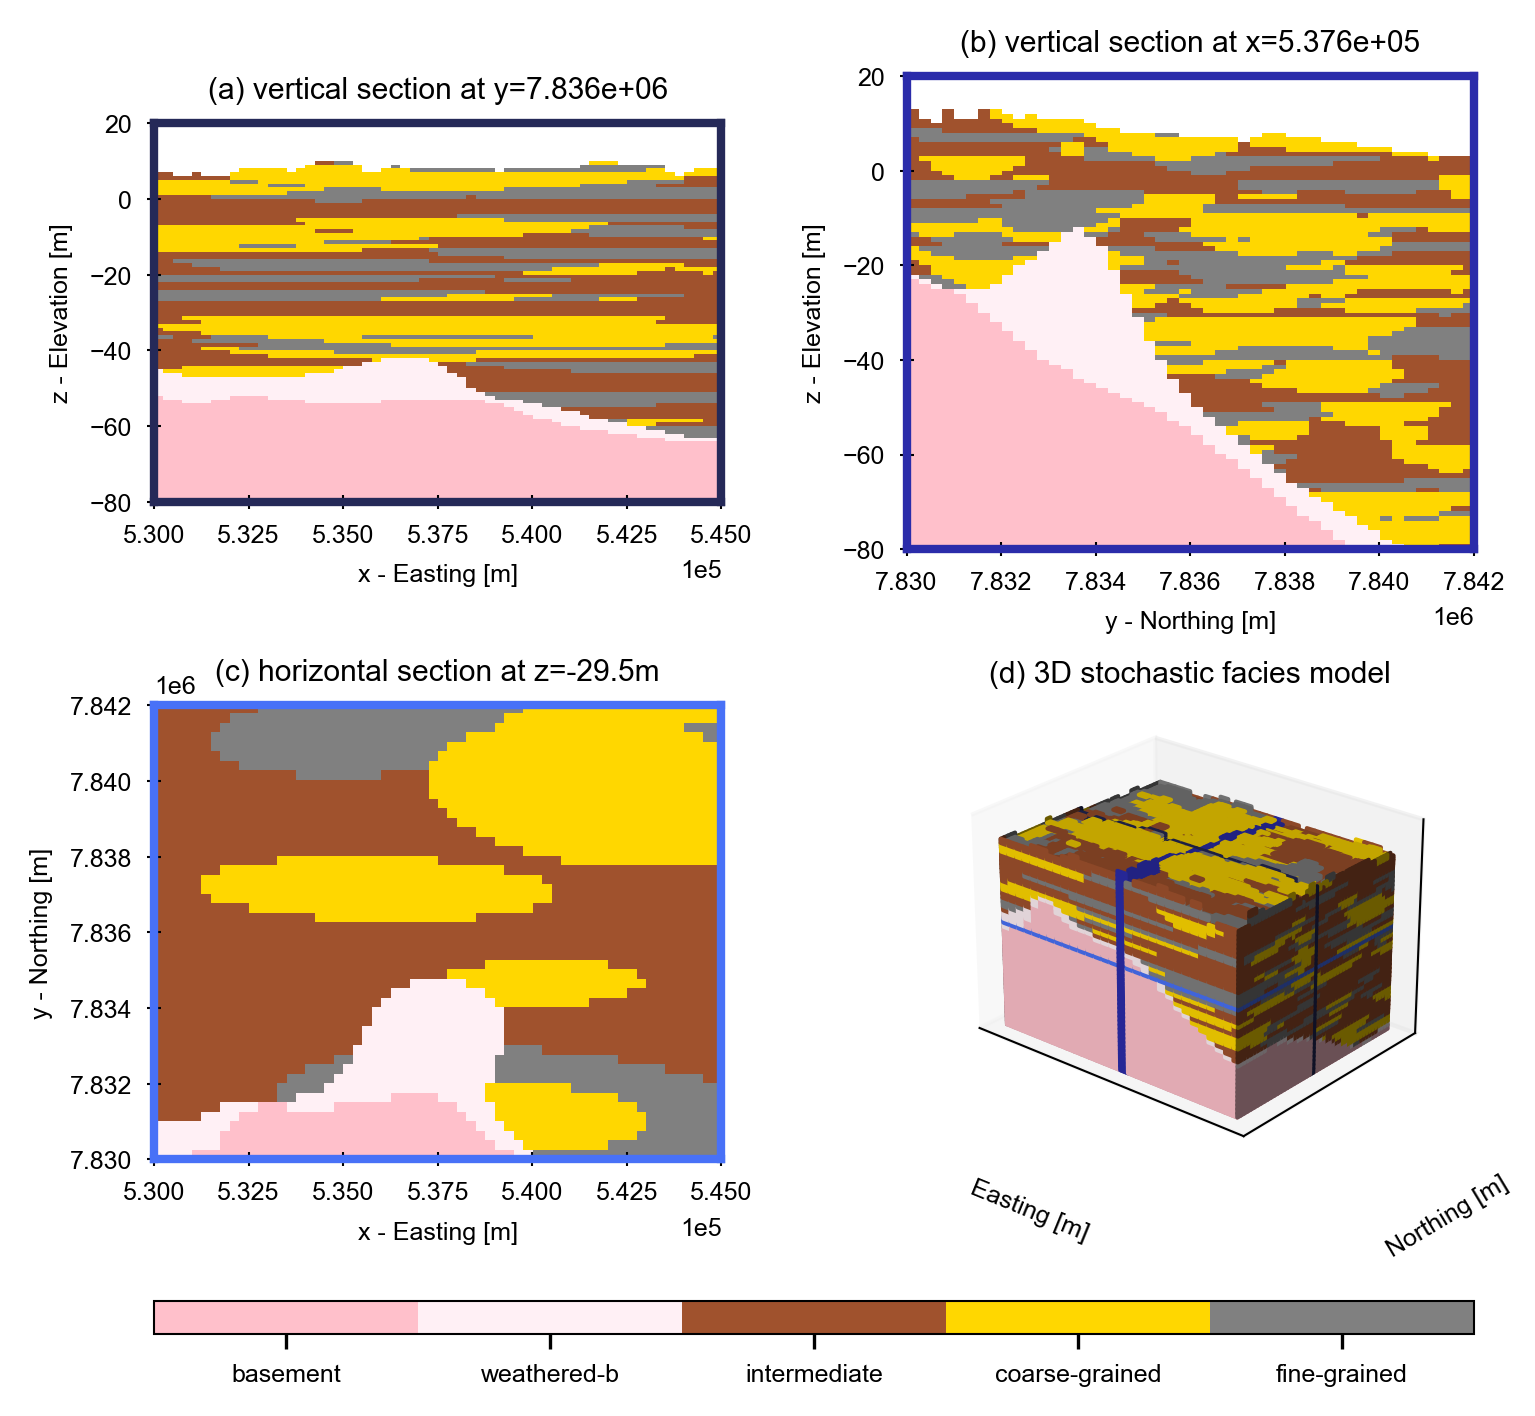

In [55]:
if plot:
    printtimelog('plotting sections - facies')
    # check plot of sections
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(lithocolors) # lavenderblush
    ix,iy,iz=30,22,50
    # FACIES PLOT
    # plot3sections(facies_mx,ix,iy,iz,'facies',cmap,aoi_vx,aoi_vy,aoi_vz,prop.loc[:,['proportion','labels']])
    figFileName=fig_fd+'fig8_3Dmodel_facies'+filename_suffix+'_'+str(fgw)+'cm_ft'+str(fts)+'.png'
    print(figFileName)
    plot3sections(facies_mx,ix,iy,iz,cmap,aoi_vx,aoi_vy,aoi_vz,labeltype='facies',
                  figsize=(fgw/2.54,fgw/15*12/2.54),fontsize=fts,figFileName=figFileName) #

26-Feb-2025 (09:45:10) - plotting sections - age
../figures/fig9_3Dmodel_age_real_2_15cm_ft6.png


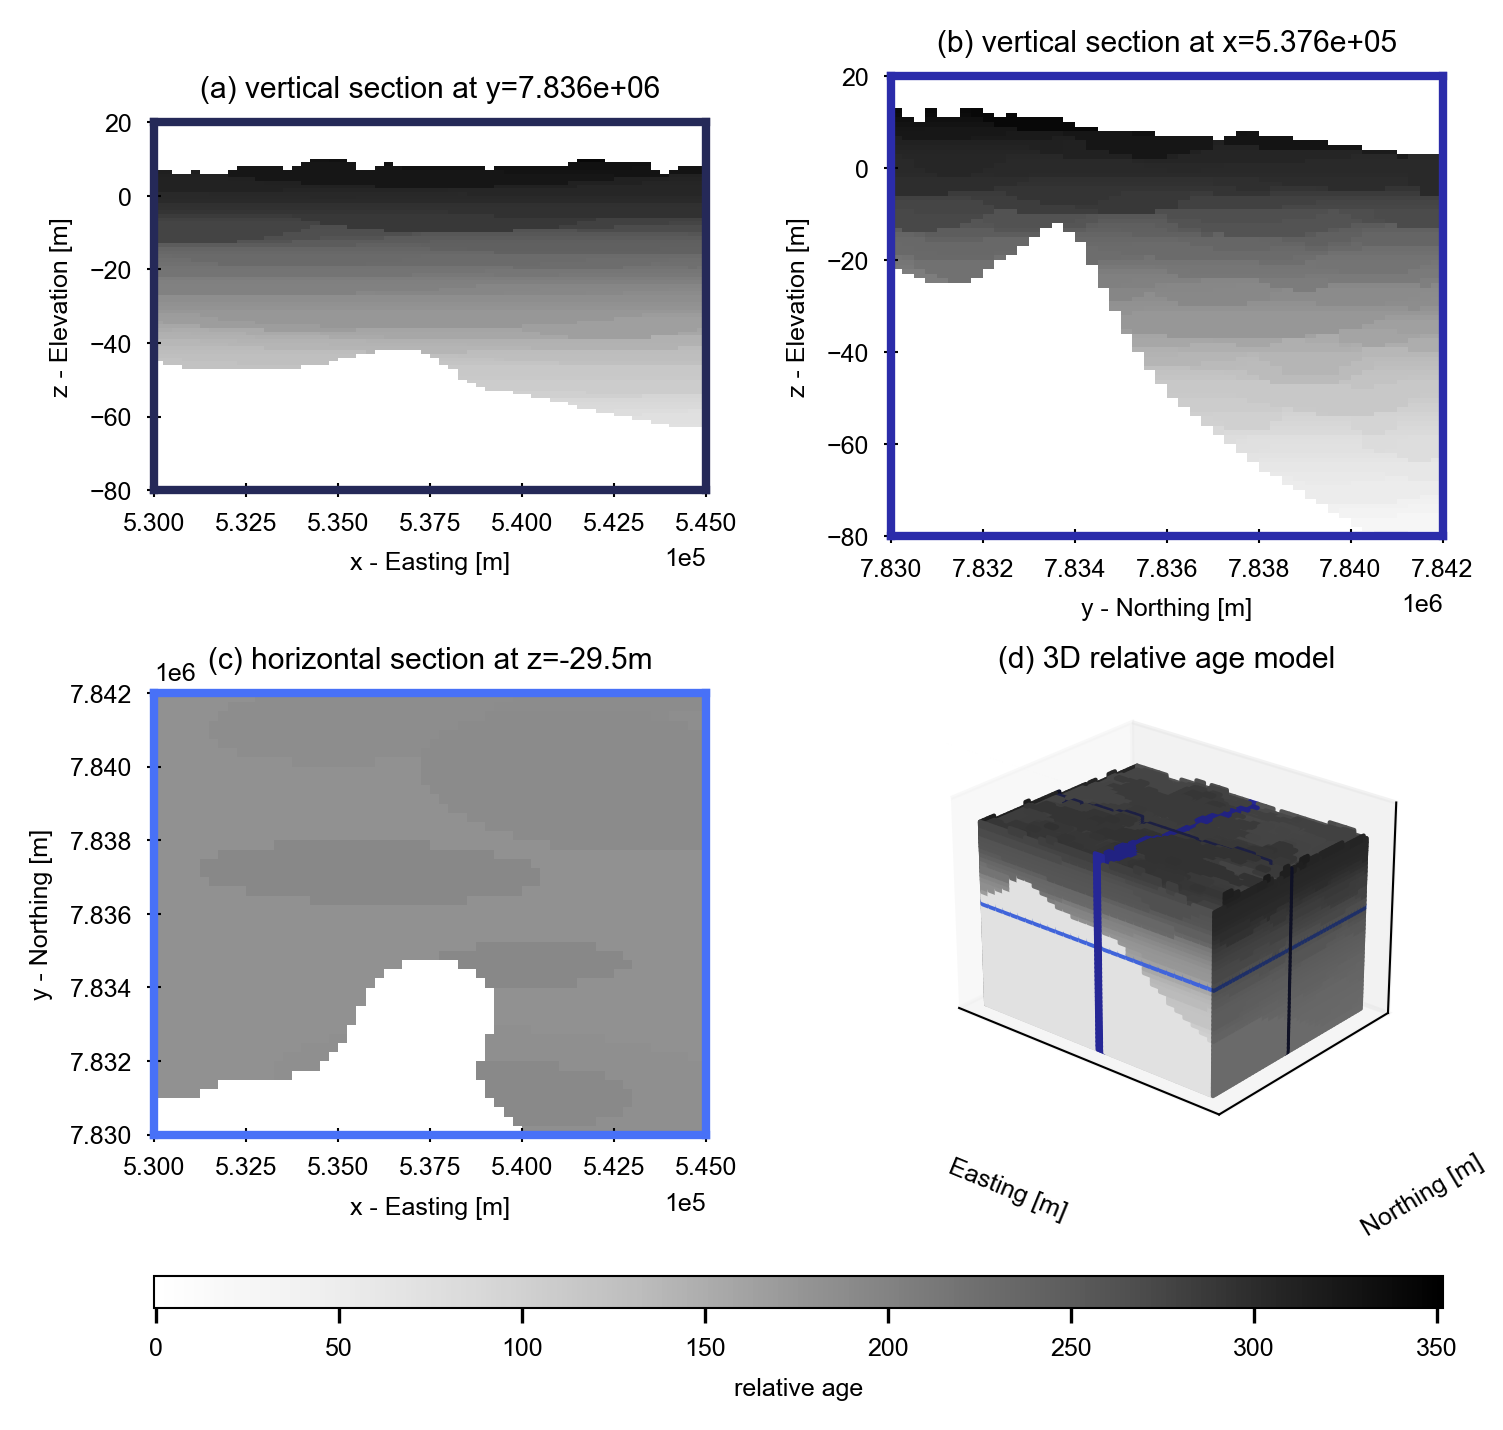

In [56]:
if plot:
    printtimelog('plotting sections - age')
    # YOUTH PLOT (-AGE)
    # plot3sections(relative_youth_mx,ix,iy,iz,'relative youth','Greys',aoi_vx,aoi_vy,aoi_vz)
    figFileName=fig_fd+'fig9_3Dmodel_age'+filename_suffix+'_'+str(fgw)+'cm_ft'+str(fts)+'.png'
    print(figFileName)
    plot3sections(relative_youth_mx,ix,iy,iz,'Greys',aoi_vx,aoi_vy,aoi_vz,labeltype='age',
                  figsize=(fgw/2.54,fgw/15*12/2.54),fontsize=fts,figFileName=figFileName) #


In [57]:
printtimelogwithstarline('FINISHED')


**********************************************************************
26-Feb-2025 (09:45:20) - FINISHED
**********************************************************************


In [58]:
# labeltype='facies'
# figsize = None 
# fontsize = None
# mx = facies_mx
# vx,vy,vz = aoi_vx,aoi_vy,aoi_vz





../figures/fig1_3Dmodel_facies_real_2_15cm_ft6.png


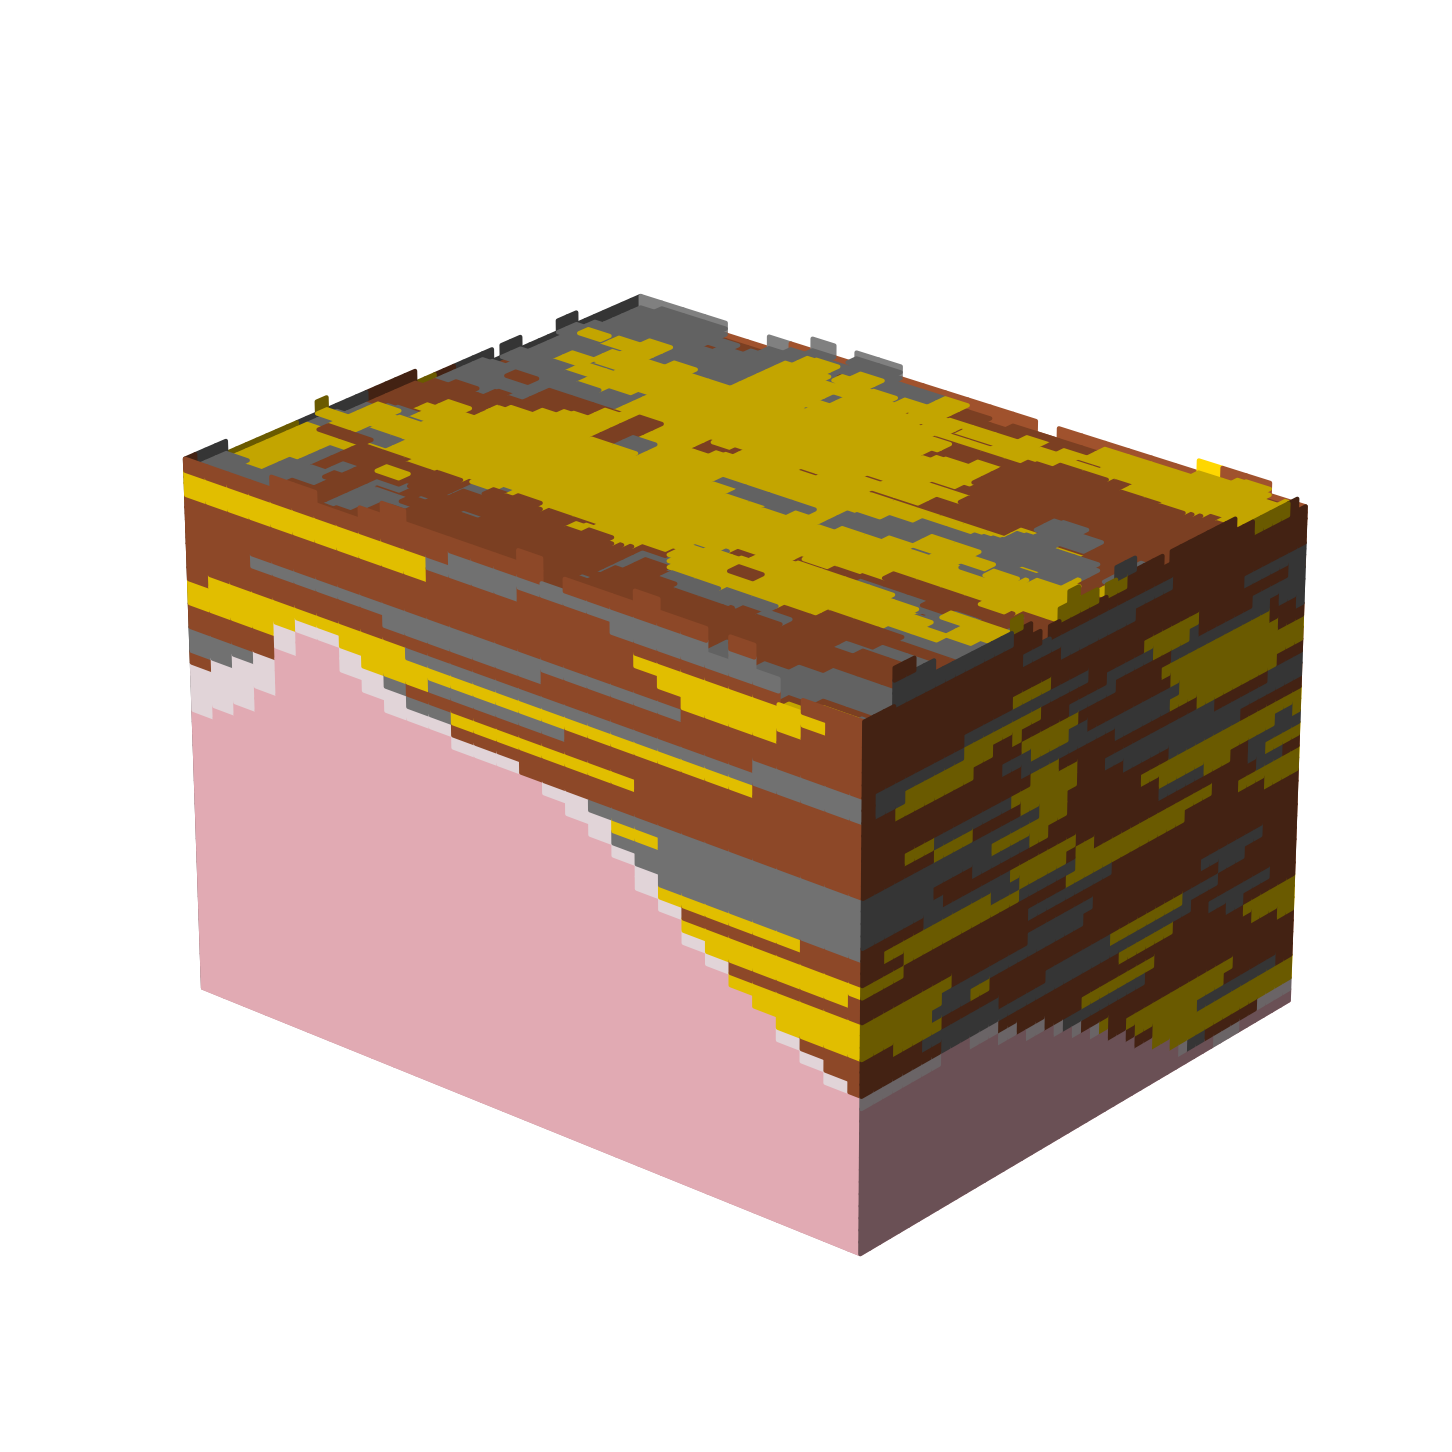

In [59]:
figFileName=fig_fd+'fig1_3Dmodel_facies'+filename_suffix+'_'+str(fgw)+'cm_ft'+str(fts)+'.png'
print(figFileName)
plot3Dreal(facies_mx,cmap,aoi_vx,aoi_vy,aoi_vz,labeltype='facies',axisOff=True,
           figsize=(fgw/2.54,fgw/15*12/2.54),fontsize=fts,figFileName=figFileName)

## VTK export

In [60]:
print('[aoi_nx,aoi_ny,aoi_nz]: ',[aoi_nx,aoi_ny,aoi_nz])
print('np.moveaxis(facies_mx,[0, 1, 2], [-1, -2, -3]).shape',np.moveaxis(facies_mx,[0, 1, 2], [-1, -2, -3]).shape)

numpy_array = np.copy(facies_mx) #np.copy(np.moveaxis(facies_mx,[0, 1, 2], [-1, -2, -3]))
# [nx,ny,nz]=numpy_array.shape
# print('[nx,ny,nz]: ', [nx,ny,nz])
print('np.unique(numpy_array): ', np.unique(numpy_array))

numpy_array[np.isnan(numpy_array)] = -2 
# np.savetxt('tmp_data.txt', numpy_array.flatten(), fmt='%i', delimiter=' ')
# print('np.unique(numpy_array): ', np.unique(numpy_array))


[aoi_nx,aoi_ny,aoi_nz]:  [60, 48, 100]
np.moveaxis(facies_mx,[0, 1, 2], [-1, -2, -3]).shape (60, 48, 100)
np.unique(numpy_array):  [-1.  0.  1.  2.  3. nan]


In [61]:

# Dimensions 
ncells = aoi_nx * aoi_ny * aoi_nz 

npoints = (aoi_nx + 1) * (aoi_ny + 1) * (aoi_nz + 1) 

# Point Coordinates 
pts_vx = np.linspace(xmin,xmax,aoi_nx+1,endpoint=True)
pts_vy = np.linspace(ymin,ymax,aoi_ny+1,endpoint=True)
pts_vz = np.linspace(zmin,zmax,aoi_nz+1,endpoint=True)

z,y,x = np.meshgrid(pts_vz,pts_vy,pts_vx,indexing='ij')

# Variables 

# pressure = np.random.rand(ncells).reshape( (nx, ny, nz)) 

# temp = np.random.rand(npoints).reshape( (nx + 1, ny + 1, nz + 1)) 

gridToVTK(output_fd+"./calibrated_model"+filename_suffix, x, y, z, cellData = {"facies" : numpy_array}) #, pointData = {"temp" : temp}

'C:\\Users\\00102908\\my-UWA\\LBD-facies-modeling\\data\\models-age-facies\\calibrated_model_real_2.vts'

### Sensitivity to sampling

Results below show that it is less than 0.6% for different sub-samples

In [20]:
df_stats_smpl_err = pd.DataFrame(columns=["err_prop_clay","err_prop_sand","err_ecdf_clay","err_ecdf_sand","dist2ref","similarity"])
# GENERATE TRUNCATED ELLIPSOID PARAMS FOR SAND LENSES AND CLAY LENSES
#printtimelog('generate lense params')
lenseClassesList = [sandLenses,clayLenses]
Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies = gen_concatenated_lenses_params(lenseClassesList,mask_aquifer,dx,dz,lbdseed+3+seed_increment)

# GENERATE OBJECT BASED MODELS
#printtimelog('generate object based model')
facies_mx,relative_youth_mx = gen_facies_youth_mx(aoi_vx,aoi_vy,aoi_vz,Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies,mask_aquifer)

# ADD DISTINCTION BETWEEN BASEMENT AND WEATHERED BASEMENT
#printtimelog('differentiate basement from weathered basement')
tmp_twt = np.tile(np.reshape(aoi_top_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
ix_bst = np.where(zzz<tmp_twt)
facies_mx[ix_bst]=-1

# COMPUTE COUNT AND PROPORTIONS PER LITHOCODE
#printtimelog('compute proportions')
prop = get_facies_prop(facies_mx,mask_aquifer,lithocodes[2:],labels[2:])
#print(prop)

for i in range(nseeds):
    print(str(i+1)+'/'+str(nseeds))
    rng = np.random.default_rng(lbdseed+i) # +seed_increment
    # GET THICKNESSES
    #printtimelog('extract thicknesses')
    df_model_thickness = get_model_litho_thickness(facies_mx,ndhsamples,aoi_nx,aoi_ny,lithocodes,zmin,dz,rng)
    
    # COMPUTE EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTIONS OF THICKNESS PER LITHOCODE
    #printtimelogwithstarline('COMPUTE ECDFs')
    x_clay, ecdf_clay = get_ecdf(df_model_thickness,3)
    x_sand, ecdf_sand = get_ecdf(df_model_thickness,2)
    x_inte, ecdf_inte = get_ecdf(df_model_thickness,1)
    
    #printtimelog('normalize ecdfs')
    
    ecdf01_clay = interp_ecdf_normalize_x(x_clay,ecdf_clay,xlim,x01_vec)
    ecdf01_sand = interp_ecdf_normalize_x(x_sand,ecdf_sand,xlim,x01_vec)
    ecdf01_inte = interp_ecdf_normalize_x(x_inte,ecdf_inte,xlim,x01_vec)
    
    #printtimelogwithstarline('COMPUTE DISTANCE TO LBD DATASET')
    #printtimelog('compute errors')
    err_prop_clay = (float(prop.loc[3,'proportion'])/100-prop_clay_mean_p5_p95[0]) # / prop_clay_err_mean_p5_p95[0]
    err_prop_sand = (float(prop.loc[2,'proportion'])/100-prop_sand_mean_p5_p95[0]) #/ prop_sand_err_mean_p5_p95[0]
    
    
    err_ecdf_clay,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_clay_mean_p5_p95[:,0],x01_vec,ecdf01_clay,nbins=nbins,plot=False) #/ ecdf_clay_area_err_mean_p5_p95[0]
    err_ecdf_sand,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_sand_mean_p5_p95[:,0],x01_vec,ecdf01_sand,nbins=nbins,plot=False) #/ ecdf_sand_area_err_mean_p5_p95[0]
    # err_ratio_ecdf_inte,_,_,_,_,_, = get_ecdf_area_difference(x01_vec,ecdf_inte_mean_p5_p95[:,0],x01_vec,ecdf01_inte,nbins=nbins) #/ ecdf_inte_area_err_mean_p5_p95[0]
    
    #printtimelog('compute distance')
    errors = np.abs(np.array([err_prop_clay,err_prop_sand,err_ecdf_clay,err_ecdf_sand]))
    #print('errors: '+str(errors))
    
    similarity = np.prod(1-errors)**(1/len(errors))
    dist2lbd = 1 - similarity

    df_stats_smpl_err.loc[i,"err_prop_clay"] = err_prop_clay
    df_stats_smpl_err.loc[i,"err_prop_sand"] = err_prop_sand
    df_stats_smpl_err.loc[i,"err_ecdf_clay"] = err_ecdf_clay
    df_stats_smpl_err.loc[i,"err_ecdf_sand"] = err_ecdf_sand
    df_stats_smpl_err.loc[i,"similarity"] = similarity
    df_stats_smpl_err.loc[i,"dist2ref"] = dist2lbd


1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


In [21]:
df_stats_smpl_err.to_csv(output_fd+stat2_fn,index=False)
df_stats_smpl_err

,err_prop_clay,err_prop_sand,err_ecdf_clay,err_ecdf_sand,dist2ref,similarity
0,0.011198,-0.003584,0.02192,0.017844,0.013661,0.986339
1,0.011198,-0.003584,0.022911,0.015784,0.013394,0.986606
2,0.011198,-0.003584,0.021834,0.014967,0.012917,0.987083
3,0.011198,-0.003584,0.022354,0.018463,0.013926,0.986074
4,0.011198,-0.003584,0.022437,0.012914,0.012556,0.987444
...,...,...,...,...,...,...
95,0.011198,-0.003584,0.023369,0.015983,0.01356,0.98644
96,0.011198,-0.003584,0.022819,0.014699,0.013099,0.986901
97,0.011198,-0.003584,0.023647,0.013755,0.013072,0.986928
98,0.011198,-0.003584,0.023722,0.018811,0.014358,0.985642


In [22]:
pct_confidence = 90
print(str(pct_confidence)+'% confidence, err_prop_clay <= '+str(np.percentile(np.abs(df_stats_smpl_err["err_prop_clay"]),pct_confidence)))
print(str(pct_confidence)+'% confidence, err_prop_sand <= '+str(np.percentile(np.abs(df_stats_smpl_err["err_prop_sand"]),pct_confidence)))
print(str(pct_confidence)+'% confidence, err_ecdf_clay <= '+str(np.percentile(df_stats_smpl_err["err_ecdf_clay"],pct_confidence)))
print(str(pct_confidence)+'% confidence, err_ecdf_sand <= '+str(np.percentile(df_stats_smpl_err["err_ecdf_sand"],pct_confidence)))
print(str(pct_confidence)+'% confidence, dist2ref <= '+str(np.percentile(df_stats_smpl_err["dist2ref"],pct_confidence)))

pct_confidence = 50
print(str(pct_confidence)+'% confidence, err_prop_clay <= '+str(np.percentile(np.abs(df_stats_smpl_err["err_prop_clay"]),pct_confidence)))
print(str(pct_confidence)+'% confidence, err_prop_sand <= '+str(np.percentile(np.abs(df_stats_smpl_err["err_prop_sand"]),pct_confidence)))
print(str(pct_confidence)+'% confidence, err_ecdf_clay <= '+str(np.percentile(df_stats_smpl_err["err_ecdf_clay"],pct_confidence)))
print(str(pct_confidence)+'% confidence, err_ecdf_sand <= '+str(np.percentile(df_stats_smpl_err["err_ecdf_sand"],pct_confidence)))
print(str(pct_confidence)+'% confidence, dist2ref <= '+str(np.percentile(df_stats_smpl_err["dist2ref"],pct_confidence)))


90% confidence, err_prop_clay <= 0.01119775150824509
90% confidence, err_prop_sand <= 0.0035837479062685307
90% confidence, err_ecdf_clay <= 0.02463770502195401
90% confidence, err_ecdf_sand <= 0.01804413189260028
90% confidence, dist2ref <= 0.014170541153188365
50% confidence, err_prop_clay <= 0.01119775150824509
50% confidence, err_prop_sand <= 0.0035837479062685307
50% confidence, err_ecdf_clay <= 0.02341410745258355
50% confidence, err_ecdf_sand <= 0.015843729990123644
50% confidence, dist2ref <= 0.013534527586942513


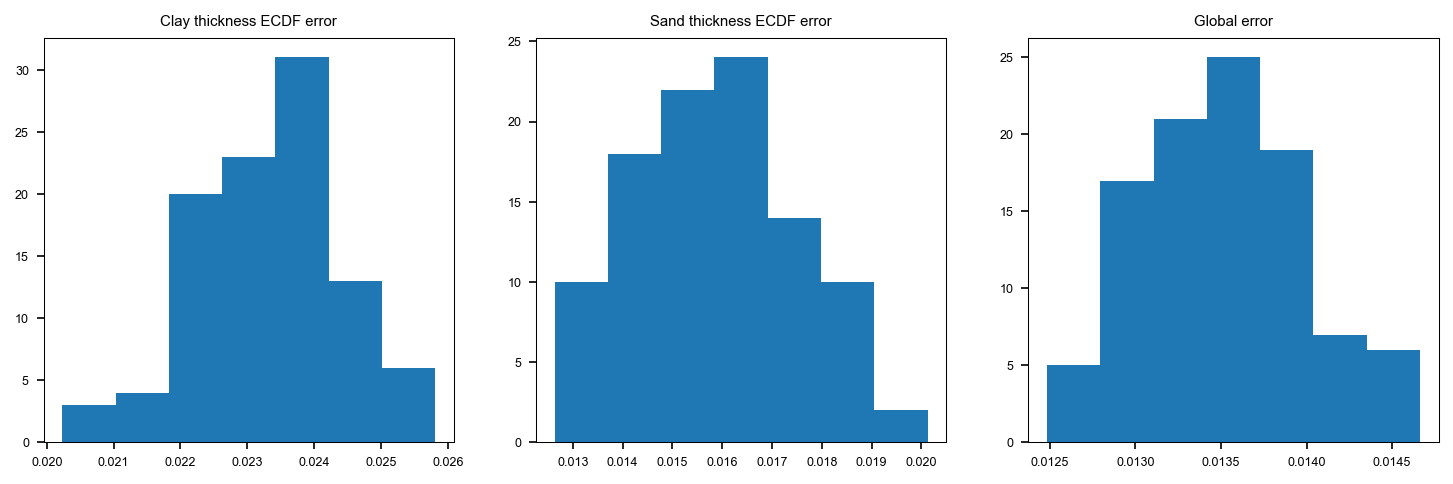

In [23]:
nbins = 7
plt.subplots(1,3,dpi=150,figsize=(12,3.5))
plt.subplot(1,3,1),plt.title('Clay thickness ECDF error')
plt.hist(df_stats_smpl_err["err_ecdf_clay"],bins=nbins)

plt.subplot(1,3,2),plt.title('Sand thickness ECDF error')
plt.hist(df_stats_smpl_err["err_ecdf_sand"],bins=nbins)

plt.subplot(1,3,3),plt.title('Global error')
plt.hist(df_stats_smpl_err["dist2ref"],bins=nbins)

plt.show()